In [1]:
% matplotlib inline
from __future__ import division
from __future__ import print_function

from astropy.io import fits
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import numpy as np

from numina.array.display.ximshow import ximshow
from numina.array.display.ximplotxy import ximplotxy

# Reduction of HD209290 (HIP 108782)


## Raw data:

Compressed tar.gz file with 6 images: [hd209290_files.tgz](http://guaix.fis.ucm.es/~ncl/temp/hd209290_files.tgz)

```bash
% tar zxvf hd209290_files.tgz
% ls *.fits
0001005263-20160727-EMIR-TEST0.fits  0001005272-20160727-EMIR-TEST0.fits
0001005266-20160727-EMIR-TEST0.fits  0001005275-20160727-EMIR-TEST0.fits
0001005269-20160727-EMIR-TEST0.fits  0001005278-20160727-EMIR-TEST0.fits
```

The content of these files can be rapidly shown using:

```bash
% dfits 000100*20160727-EMIR-TEST0.fits | fitsort object grism filter exptime date-obs
FILE                               	OBJECT    	GRISM  	FILTER  EXPTIME 	DATE-OBS              	
0001005263-20160727-EMIR-TEST0.fits	HYP 108782	K      	Ksp     9.999289	2016-07-28T04:57:13.05	
0001005266-20160727-EMIR-TEST0.fits	HYP 108782	K      	Ksp     9.999289	2016-07-28T04:58:43.51	
0001005269-20160727-EMIR-TEST0.fits	HYP 108782	H      	H       9.999289	2016-07-28T05:01:55.18	
0001005272-20160727-EMIR-TEST0.fits	HYP 108782	H      	H       9.999289	2016-07-28T05:03:28.79	
0001005275-20160727-EMIR-TEST0.fits	HYP 108782	J      	J       9.999289	2016-07-28T05:08:25.88	
0001005278-20160727-EMIR-TEST0.fits	HYP 108782	J      	J       9.999289	2016-07-28T05:09:21.54
```

The CSU configuration can be displayed with:
```bash
% pyemir-display_slitlet_arrangement 000100*20160727-EMIR-TEST0.fits
```

![](reduction_hd209290/display_slitlet_arrangement_pyemir-display_slitlet_arrangement_000100*20160727-EMIR-TEST0.fits.png)
![](reduction_hd209290/display_slitlet_arrangement_pyemir-display_slitlet_arrangement_000100*20160727-EMIR-TEST0_zoom.fits.png)

## Reduction of the stellar spectra (A - B)

<div class="alert alert-block alert-info">
The following steps are going to be carried out with the grims J + filter J images. For the other settings the steps are similar.
</div>

### Subtraction of consecutive images to remove the sky spectrum:

```bash
% numina-imath 0001005278-20160727-EMIR-TEST0.fits - 0001005275-20160727-EMIR-TEST0.fits grismJ_A-B.fits
```

The resulting image can be easily displayed
```bash
% numina-ximshow grismJ_A-B.fits
```
![](reduction_hd209290/images/grismJ_A-B_ximshow1.png)
![](reduction_hd209290/images/grismJ_A-B_ximshow2.png)


### Apply bad-pixel mask

The file `BadPixeMask_F.fits` is available in the [calibrations](calibrations.html) page.

```bash
% numina-bpm grismJ_A-B.fits --bpm BadPixMask_F.fits --outfile grismJ_A-B_bpm.fits
```

### Overplot of slitlet boundaries

```bash
% pyemir-overplot_boundary_model grismJ_A-B_bpm.fits \
  --fitted_bound_param refined_multislit_param_grism_J_filter_J.json \
  --ds9reg_boundaries ds9_boundaries_grismJ_A-B.reg \
  --ds9reg_frontiers ds9_frontiers_grismJ_A-B.reg
```
![](reduction_hd209290/images/grismJ_A-B_overplot_boundary1.png)
![](reduction_hd209290/images/grismJ_A-B_overplot_boundary2.png)
![](reduction_hd209290/images/ds9_boundaries.png)


### Flatfield (pixel-to-pixel variation)

```bash
% numina-imath grismJ_A-B_bpm.fits / continuum_ls06_J_J_on-off_flat.fits grismJ_A-B_flat.fits
```

### Rectification and wavelength calibration

```bash
% pyemir-apply_rect_wpoly grismJ_A-B_flat.fits \
  --coef_rect_wpoly coef_rect_wpoly_ls06_grism_J_filter_J_direct_verified.json \
  --ignore_DTUconf \
  --outfile grismJ_A-B_rectwv.fits
```

### Spectrum extraction

In [12]:
# read FITS image
with fits.open('reduction_hd209290/grismJ_A-B_rectwv.fits', mode='readonly') as hdulist:
    image_header = hdulist[0].header
    image_data = hdulist[0].data
    
# image dimensions
naxis2, naxis1 = image_data.shape

# read wavelength calibration from header
crpix1 = image_header['crpix1']
crval1 = image_header['crval1']
cdelt1 = image_header['cdelt1']
exptime = image_header['exptime']
print('crpix1, crval1, cdelt1:', crpix1, crval1, cdelt1)
print('exptime:', exptime)

crpix1, crval1, cdelt1: 1.0 11220.0 0.7575
exptime: 9.999289


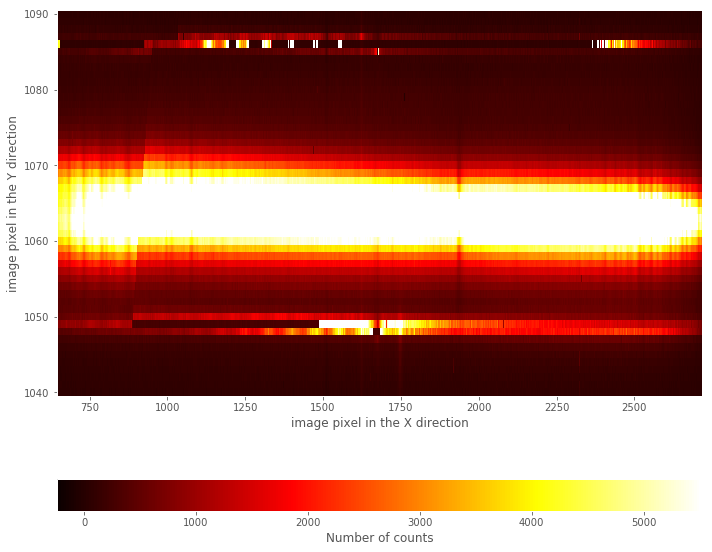

In [13]:
ximshow(image_data, image_bbox=(645,2717,1040,1090), geometry=None, debugplot=1)

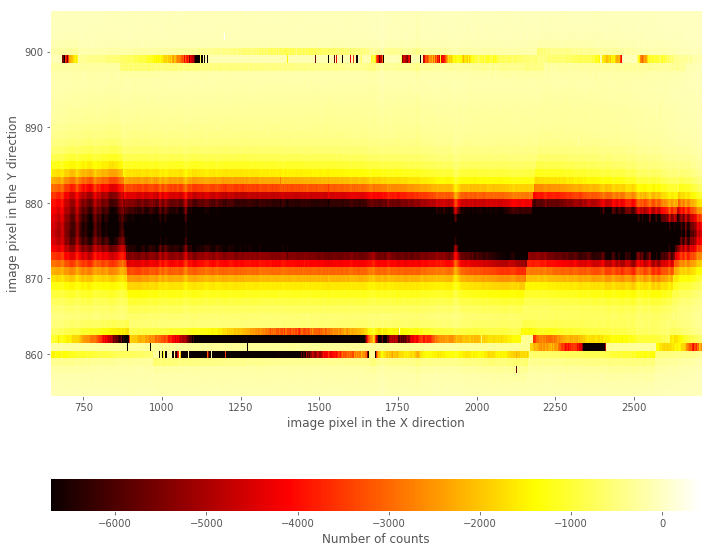

In [14]:
ximshow(image_data, image_bbox=(645,2717,855,905), geometry=None, debugplot=1)


In [79]:
# extract and coadd individual spectra by coadding rows
sp1 = np.sum(image_data[1052:1084,], axis=0)
sp2 = -np.sum(image_data[861:891,], axis=0)
# sum of two spectra
spectrum = sp1 + sp2
# compute counts/second
spectrum = spectrum / (2 * exptime)

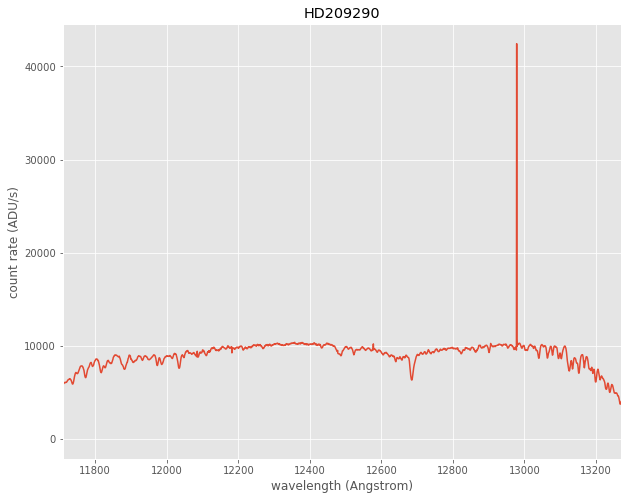

In [80]:
# plot spectrum
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
ax.plot(wave, spectrum)
wvmin = 11710
wvmax = 13270
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel('count rate (ADU/s)')
ax.set_title('HD209290')

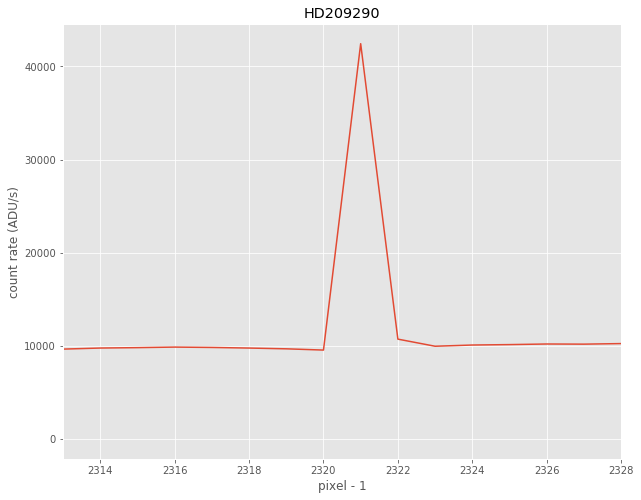

In [81]:
# plot spectrum: zoom in bad pixels
fig, ax = plt.subplots()
xpixel = np.arange(naxis1)
ax.plot(xpixel, spectrum)
ax.set_xlim([2313, 2328])
ax.set_xlabel('pixel - 1')
ax.set_ylabel('count rate (ADU/s)')
ax.set_title('HD209290')

In [82]:
good_pixels = range(2314, 2329)
bad_pixels = 2321
good_pixels.remove(bad_pixels)
print(good_pixels)
spectrum[bad_pixels] = np.mean(spectrum[good_pixels])

[2314, 2315, 2316, 2317, 2318, 2319, 2320, 2322, 2323, 2324, 2325, 2326, 2327, 2328]


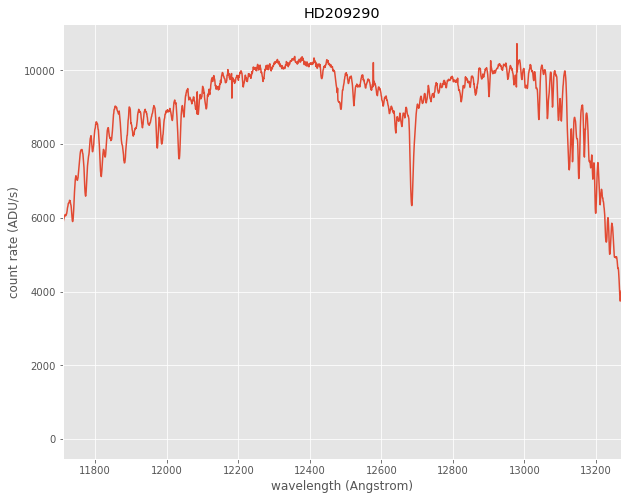

In [83]:
# plot spectrum
fig, ax = plt.subplots()
wave = crval1 + (np.arange(1, naxis1 + 1) - crpix1) * cdelt1
ax.plot(wave, spectrum)
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel('count rate (ADU/s)')
ax.set_title('HD209290')

In [84]:
# save spectrum into FITS file
hdu_sp = fits.PrimaryHDU(data=sp, header=image_header)
hdu_sp.writeto('reduction_hd209290/grismJ_hd209290.fits', overwrite=True)

### Flux calibration

The flux calibrated spectrum of this star can be found in: http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/index_files/M.html, in particular see the file: http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/M0.5V_HD209290.txt

In [85]:
# read absolute flux calibration for the star
table_flux_tabulated = np.genfromtxt(
    "http://irtfweb.ifa.hawaii.edu/~spex/IRTF_Spectral_Library/Data/M0.5V_HD209290.txt"
)
print(table_flux_tabulated)

[[  8.07453000e-01   1.48435000e-11   3.48790000e-14]
 [  8.07655000e-01   1.49206000e-11   3.50939000e-14]
 [  8.07858000e-01   1.49463000e-11   3.50331000e-14]
 ..., 
 [  5.42289300e+00  -9.99000000e+02  -9.99000000e+02]
 [  5.42389800e+00  -9.99000000e+02  -9.99000000e+02]
 [  5.42490300e+00  -9.99000000e+02  -9.99000000e+02]]


In [86]:
# Wavelength (microns): convert to Angstrom
xtab = table_flux_tabulated[:,0] * 10000
# Flux Density (W m-2 um-1)
ytab = table_flux_tabulated[:,1]

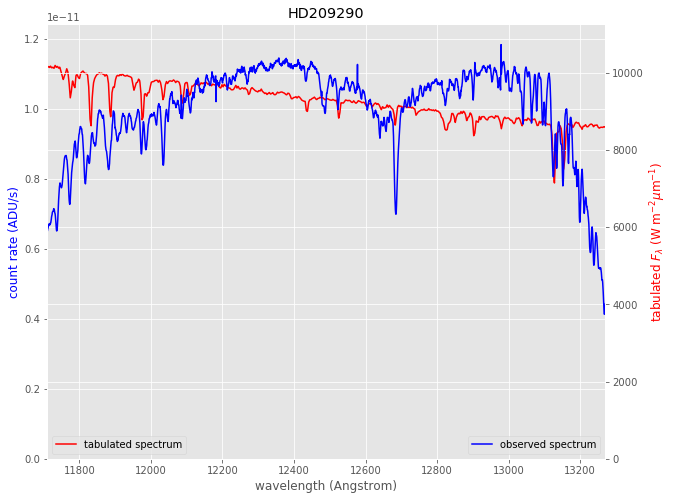

In [96]:
# resample previous spectrum to sampling of observed spectrum
from scipy.interpolate import interp1d
funinterp = interp1d(xtab, ytab, kind="linear")
yflux = funinterp(wave)

# plot observed spectrum and tabulated data
fig, ax = plt.subplots()
ax.plot(wave, yflux, 'r-', label='tabulated spectrum')
ax.set_ylim([0, yflux.max()*1.05])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel('count rate (ADU/s)', color='b')
ax.set_title('HD209290')
ax.legend(loc=3)
ax2 = ax.twinx()
ax2.plot(wave, spectrum, 'b-', label='observed spectrum')
ax2.set_ylim([0, spectrum.max()*1.05])
ax2.set_xlim([wvmin, wvmax])
ax2.set_ylabel(r'tabulated $F_\lambda$ (W m$^{-2} \mu\rm{m}^{-1}$)', color='r')
ax2.legend(loc=4)


Since the spectral resolution of the tabulated spectrum is worse than the one in the observed spectrum, we convolve the observed spectrum (using gaussian kernel).

(11710, 13270)

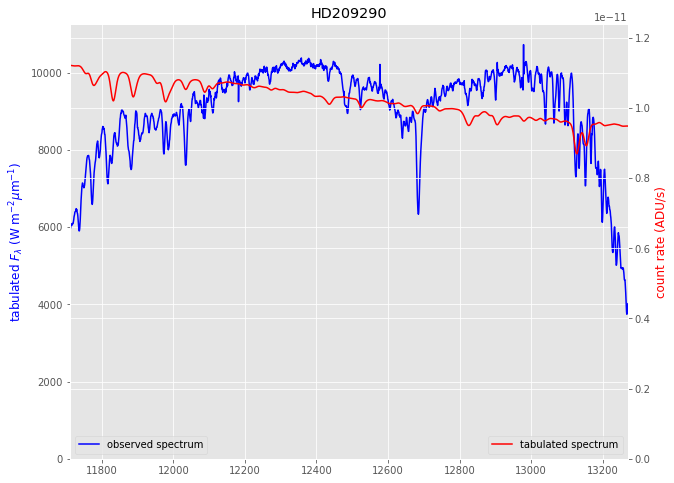

In [108]:
from scipy.ndimage.filters import gaussian_filter
sigma_obs = 3  # by 'eye'
yflux = gaussian_filter(yflux, sigma=sigma_obs)

# repeat previous plot
fig, ax = plt.subplots()
ax.plot(wave, spectrum, 'b-', label='observed spectrum')
ax.set_ylim([0, spectrum.max()*1.05])
ax.set_ylabel(r'tabulated $F_\lambda$ (W m$^{-2} \mu\rm{m}^{-1}$)', color='b')
ax.legend(loc=3)
ax2 = ax.twinx()
ax2.plot(wave, yflux, 'r-', label='tabulated spectrum')
ax2.set_ylim([0, yflux.max()*1.05])
ax2.set_xlabel('wavelength (Angstrom)')
ax2.set_ylabel('count rate (ADU/s)', color='r')
ax2.set_title('HD209290')
ax2.legend(loc=4)
ax2.set_xlim([wvmin, wvmax])

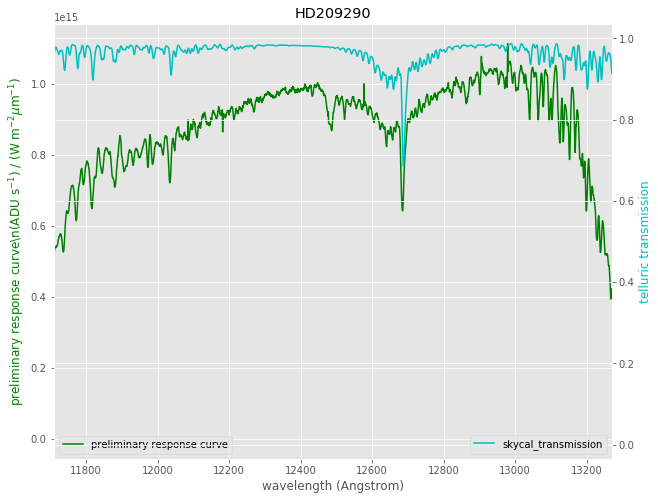

In [119]:
# preliminary response curve
yratio = spectrum / yflux

# read telluric transmission
telluric_tabulated = np.genfromtxt("reduction_hd209290/skycalc_transmission_R20000.txt")
xtab = telluric_tabulated[:,0] * 10  # convert from nm to Angstrom
ytab = telluric_tabulated[:,1]
# resample previous spectrum to sampling of observed spectrum
funinterp = interp1d(xtab, ytab, kind="linear")
ytelluric = funinterp(wave)
sigma_tel = 3
ytelluric = gaussian_filter(ytelluric, sigma=sigma_tel)

# plot
fig, ax = plt.subplots()
ax.plot(wave, yratio, 'g', label='preliminary response curve')
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'preliminary response curve\n(ADU s$^{-1}$) / (W m$^{-2} \mu\rm{m}^{-1})$', color='g')
ax.set_title('HD209290')
ax.legend(loc=3)
ax2 = ax.twinx()
ax2.plot(wave, ytelluric, 'c', label='skycal_transmission')
ax2.set_xlim([wvmin, wvmax])
ax2.set_xlabel('wavelength (Angstrom)')
ax2.set_ylabel('telluric transmission', color='c')
ax2.legend(loc=4)

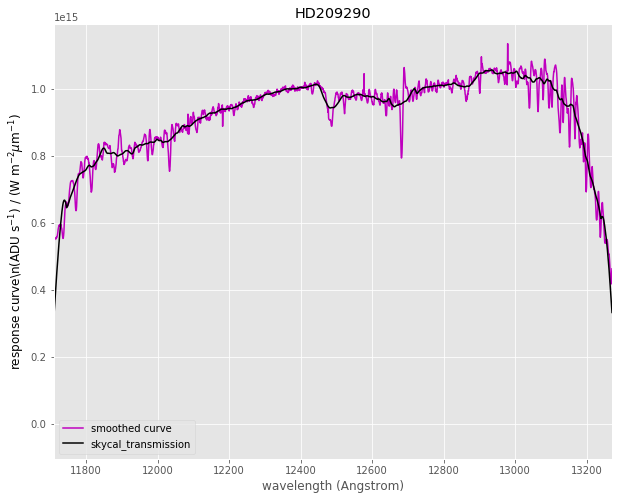

In [135]:
# ratio between response curve and atmosphere transmission
yratioplus = yratio / ytelluric

# smoothed version of previous curve
from scipy.signal import savgol_filter
yratiosmooth = savgol_filter(yratioplus, window_length=101, polyorder=2)

# plot
fig, ax = plt.subplots()
ax.plot(wave, yratioplus, 'm', label='smoothed curve')
ax.set_xlim([wvmin, wvmax])
ax.set_xlabel('wavelength (Angstrom)')
ax.set_ylabel(r'response curve\n(ADU s$^{-1}$) / (W m$^{-2} \mu\rm{m}^{-1})$', color='k')
ax.set_title('HD209290')
ax.plot(wave, yratiosmooth, 'k', label='skycal_transmission')
ax.set_xlim([wvmin, wvmax])
ax.legend(loc=3)

In [136]:
# save smoothed response curve
hdu_sp = fits.PrimaryHDU(data=yratiosmooth, header=image_header)
hdu_sp.writeto('reduction_hd209290/grismJ_response_curve_hd209290.fits', overwrite=True)